In [12]:
# Hyperparameter Tuning for Random Forest Regressor

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# File paths
INPUT_FILE = "/Users/aryan/Desktop/PrognosticEngine/data/train_FD001_features_enhanced.csv"

# Load the dataset
def load_data(file_path):
    """Load the dataset into a Pandas DataFrame."""
    return pd.read_csv(file_path)

# Ensure no overlap between training and validation sets
def split_by_engine(df):
    """Randomly split data by engine_id to prevent data leakage."""
    engine_ids = df['engine_id'].unique()
    train_engines, val_engines = train_test_split(engine_ids, test_size=0.2, random_state=42)

    train_data = df[df['engine_id'].isin(train_engines)]
    val_data = df[df['engine_id'].isin(val_engines)]

    return train_data, val_data

# Split features and target
def split_features_target(df, target_column='RUL'):
    """Split the dataset into features (X) and target (y)."""
    X = df.drop(columns=[target_column, 'engine_id', 'cycle'])
    y = df[target_column]
    return X, y

# Standardize features
def standardize_features(X, scaler=None):
    """Standardize the feature set using StandardScaler."""
    if scaler is None:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = scaler.transform(X)
    return pd.DataFrame(X_scaled, columns=X.columns), scaler

# Evaluate model
def evaluate_model(model, X_val, y_val):
    """Evaluate a trained model on validation data."""
    predictions = model.predict(X_val)

    rmse = mean_squared_error(y_val, predictions, squared=False)
    mae = mean_absolute_error(y_val, predictions)
    r2 = r2_score(y_val, predictions)

    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R^2 Score: {r2:.4f}")

if __name__ == "__main__":
    print("Loading data...")
    data = load_data(INPUT_FILE)

    print("Splitting data by engine_id to avoid data leakage...")
    train_data, validation_data = split_by_engine(data)

    print("Preparing features and target...")
    X_train, y_train = split_features_target(train_data)
    X_val, y_val = split_features_target(validation_data)

    print("Standardizing features...")
    X_train, scaler = standardize_features(X_train)
    X_val, _ = standardize_features(X_val, scaler)

    print("Hyperparameter tuning for Random Forest...")
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

    print("Fitting the model with GridSearchCV...")
    grid_search.fit(X_train, y_train)

    print("Best Hyperparameters:", grid_search.best_params_)
    print("Best Score:", -grid_search.best_score_)

    print("Evaluating the best model on validation data...")
    best_rf = grid_search.best_estimator_
    evaluate_model(best_rf, X_val, y_val)

    print("Hyperparameter tuning complete.")


Loading data...
Splitting data by engine_id to avoid data leakage...
Preparing features and target...
Standardizing features...
Hyperparameter tuning for Random Forest...
Fitting the model with GridSearchCV...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  16.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  16.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  16.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  16.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  16.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  17.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  33.9s
[CV] END max_depth=10, min

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Top 10 Important Features:
                         Feature  Importance
101   sensor_measurement_4_roll5    0.370522
108  sensor_measurement_11_roll5    0.173127
106   sensor_measurement_9_roll5    0.066936
87    sensor_measurement_9_roll3    0.025803
111  sensor_measurement_14_roll5    0.025671
112  sensor_measurement_15_roll5    0.015331
104   sensor_measurement_7_roll5    0.014173
116  sensor_measurement_21_roll5    0.012998
105   sensor_measurement_8_roll5    0.011164
109  sensor_measurement_12_roll5    0.008880


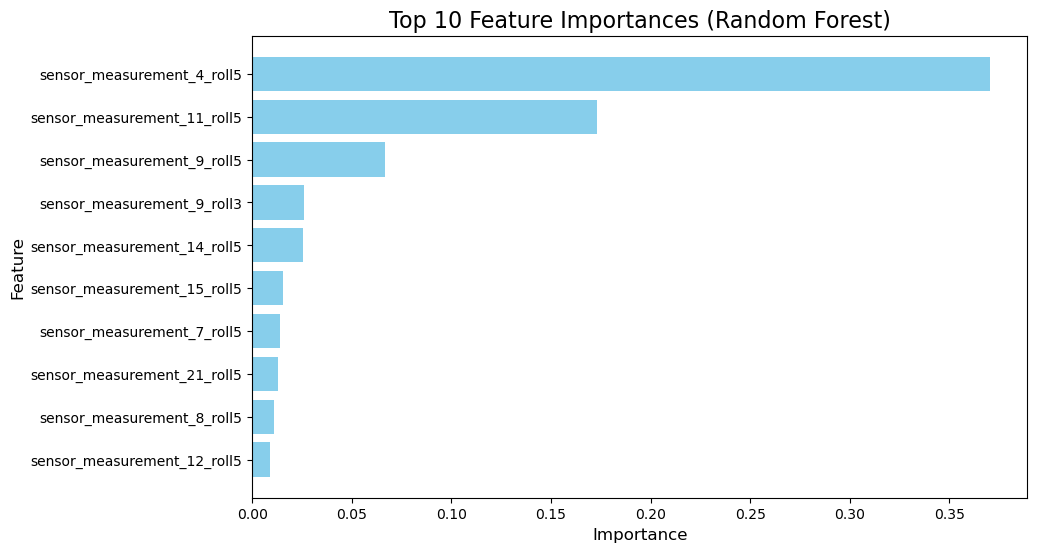

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract feature importances from the Random Forest model
importances = rf_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Display the top 10 important features
print("Top 10 Important Features:")
print(importance_df.head(10))

# Plot the top 10 important features
plt.figure(figsize=(10, 6))
top_features = importance_df.head(10)
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title("Top 10 Feature Importances (Random Forest)", fontsize=16)
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()
